# Machine Learning: House Sales Price Prediction Models

Flora He

## Introduction & Motivation
In this project, we aim to use machine learning and statistical modeling to estimate the sale price of residential houses based on a range of home features from Iowa, which includes detailed information on 79 different variables for houses sold between 2006 and 2010. The question we pursue is what model was best at predicting SalesPrice and
understanding which factors have the greatest impact on house prices. Since we have many features, we will try a variety of feature selection methods and train models using ensemble methods, including RandomForest, Bagging, and XGboost.

## Dataset
The data was collected from Ames, Iowa, including 79 explanatory variables (43 categorical and 36 numeric) across 2919 houses. Source: https://www.kaggle.com/c/home-data-for-ml-course/data.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
# !pip install xgboost
from xgboost import XGBRegressor

In [39]:
import data
data = pd.read_csv("train.csv", index_col=0)
train_with_y = data

# overview of data
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


## Data Cleaning

We will start with combining and dropping features with similar meanings.

In [41]:
# drop response variable
data = data.drop("SalePrice", axis = 1)

# count numeric variables
num_vars = data.select_dtypes(include='number').shape[1]

# count categorical variables (object or category types)
cat_vars = data.select_dtypes(include=['object', 'category']).shape[1]

print(f"Number of numeric variables: {num_vars}")
print(f"Number of categorical variables: {cat_vars}")

Number of numeric variables: 36
Number of categorical variables: 43


In [43]:
# Data Clearning: combine and drop variables

# there is a variable for total basement area (TotalBsmtSF), so we drop unnecessary variables
data = data.drop(["BsmtFinSF1","BsmtFinSF2"], axis = 1)

# sum up porch areas, then drop unnecessary variables
data["PorchArea"] = data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"]
data = data.drop(["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"], axis = 1)

# sum up bathrooms, then drop unnecessary variables
data["Baths"] = data["BsmtFullBath"] + data["BsmtHalfBath"] + data["FullBath"] + data["HalfBath"]
data = data.drop(["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"], axis = 1)

In [45]:
# numeric variables
num_vars = data.select_dtypes(include='number').drop(['MSSubClass'], axis=1).copy()

# discontinuous variables
disc_num_var = ['OverallQual','OverallCond','Baths','BedroomAbvGr', 'KitchenAbvGr', 
                'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

# continuous variables
cont_num_var = []
for i in num_vars.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

In [47]:
# redefine both types of variables
num_vars = data.select_dtypes(include='number')
cat_vars = data.select_dtypes(include=['object', 'category'])

###  For continous variables, we graph histograms to show distribution (frequency)

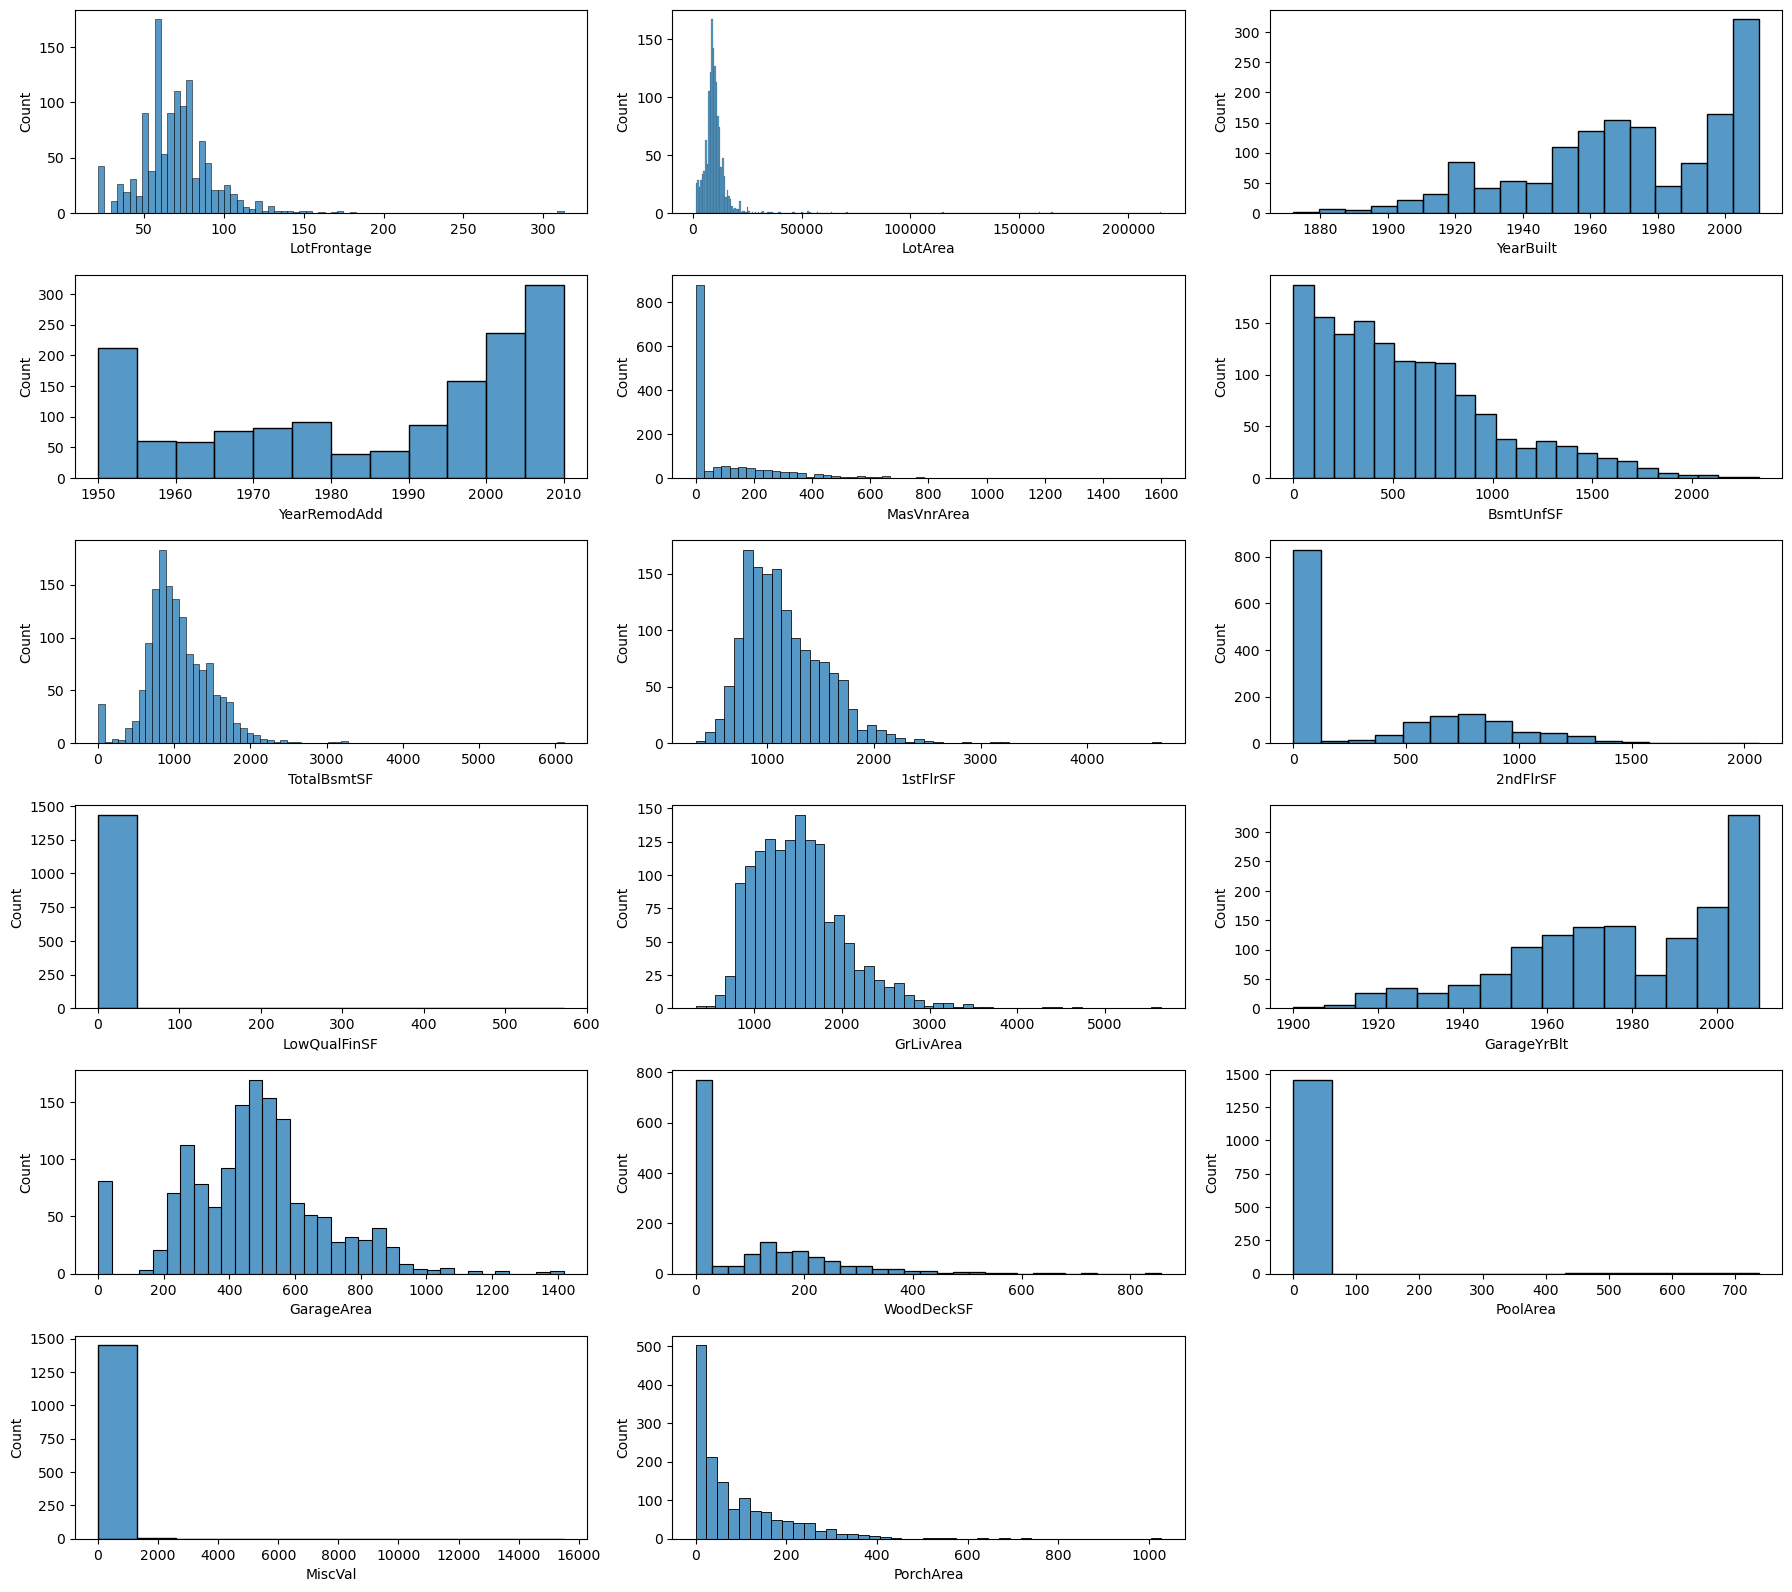

In [50]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,3,index+1)
    sns.histplot(num_vars.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

### From the histograms above, the following variables exhibit highly skewed distributions, with most values being 0:

- `LowQualFinSF`
- `PoolArea`
- `MiscVal`

These features provide little to no useful information for predicting housing prices due to the dominance of a single value (mostly 0s). Therefore, we will remove them during the preprocessing step to **simplify the model and reduce noise**.


###  Next, we draw boxplots to visualize the value distributions of each continuous variable

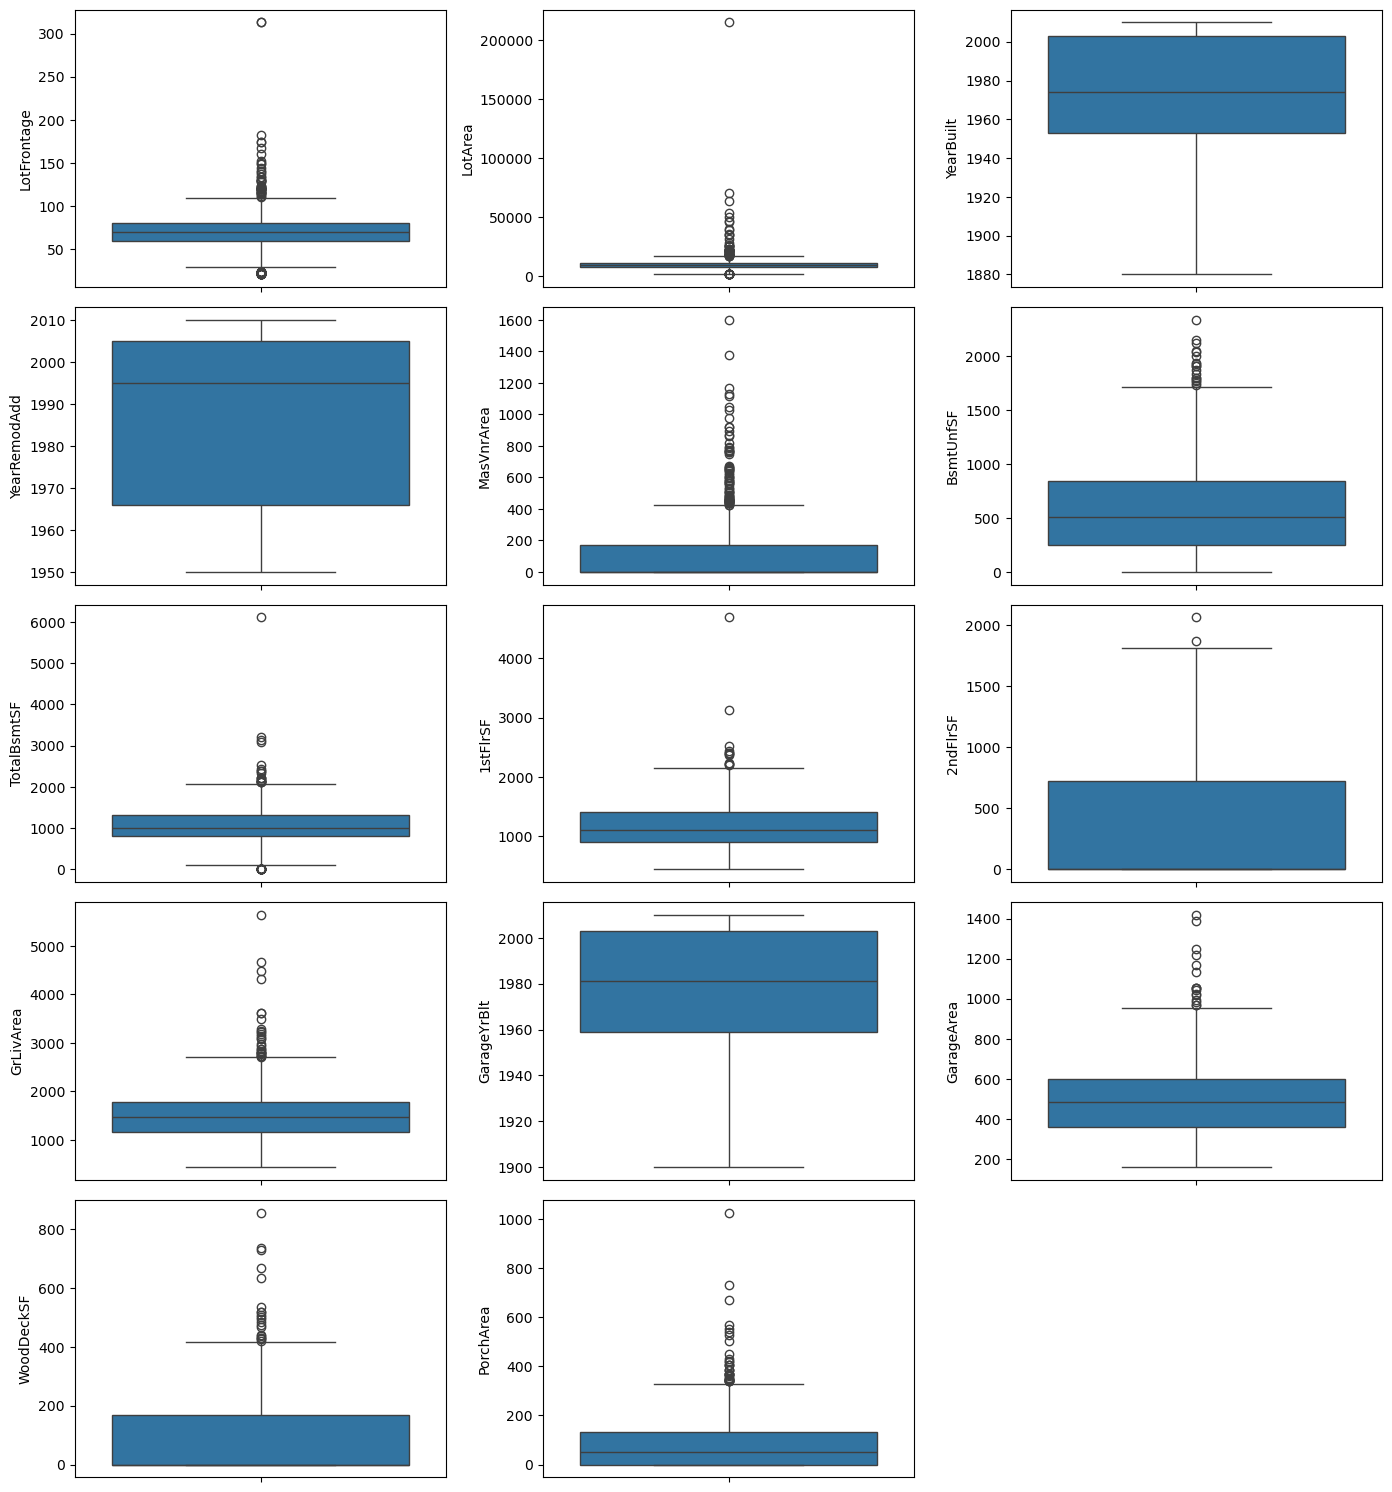

In [54]:
# remove highly skewed features
values_to_remove = ["LowQualFinSF", "PoolArea", "MiscVal"]
data = data.drop(values_to_remove, axis = 1)
cont_num_var = [x for x in cont_num_var if x not in values_to_remove]

# plot boxplots
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(cont_num_var):
    plt.subplot(5,3,index+1)
    sns.boxplot(y=col, data=num_vars.dropna())
fig.tight_layout(pad=1.0)

### From the boxplot, we can pinpoint the following features with extreme outliers:

- `LotFrontage`
- `LotArea`
- `MasVnrArea`
- `TotalBsmtSF`
- `GrLivArea`
- `PorchArea`

We remove features with extreme outliers to **prevent our models performance from being affected by extreme values**.

### Now, we move on to discontinuous variables and plot bar graphs to show their distributions

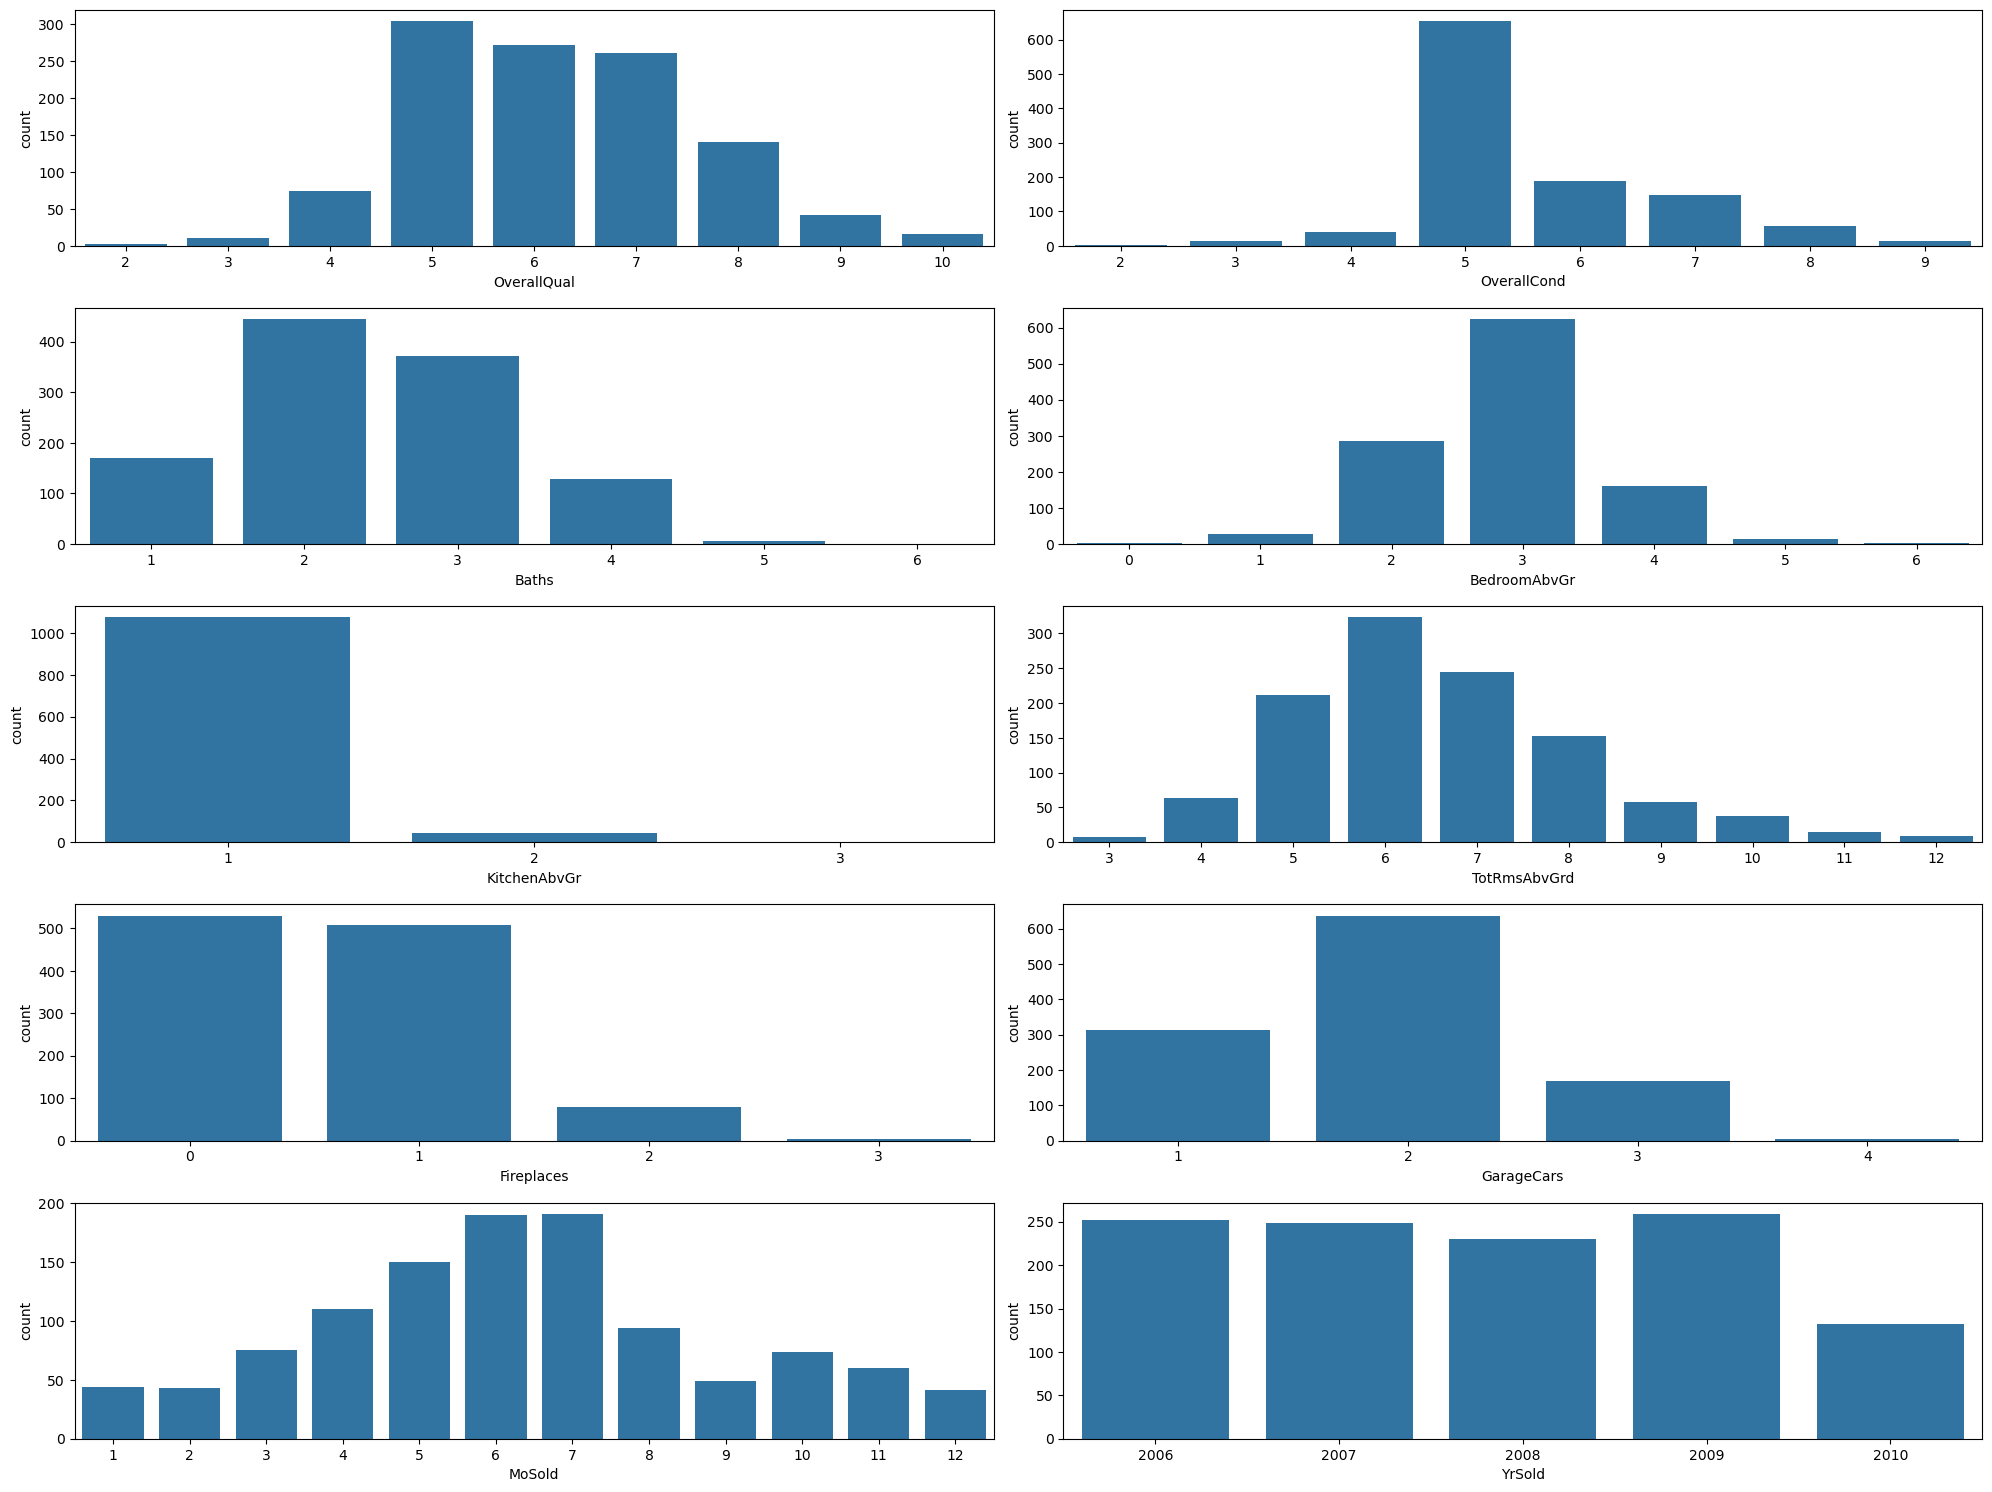

In [56]:
# remove features with extreme outliers
values_to_remove = ["LotFrontage", "LotArea", "MasVnrArea", "TotalBsmtSF", "GrLivArea", "PorchArea"]
data = data.drop(values_to_remove, axis = 1)
cont_num_var = [x for x in cont_num_var if x not in values_to_remove]

# bar plots
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(disc_num_var):
    plt.subplot(5,2,index+1)
    sns.countplot(x=col, data=num_vars.dropna())
fig.tight_layout(pad=1.0)

### The distributions of discontinuous variables look decent, so we move on to examine categorical features variables

### We use bar plots to visualize the count of each distinct value within each feature

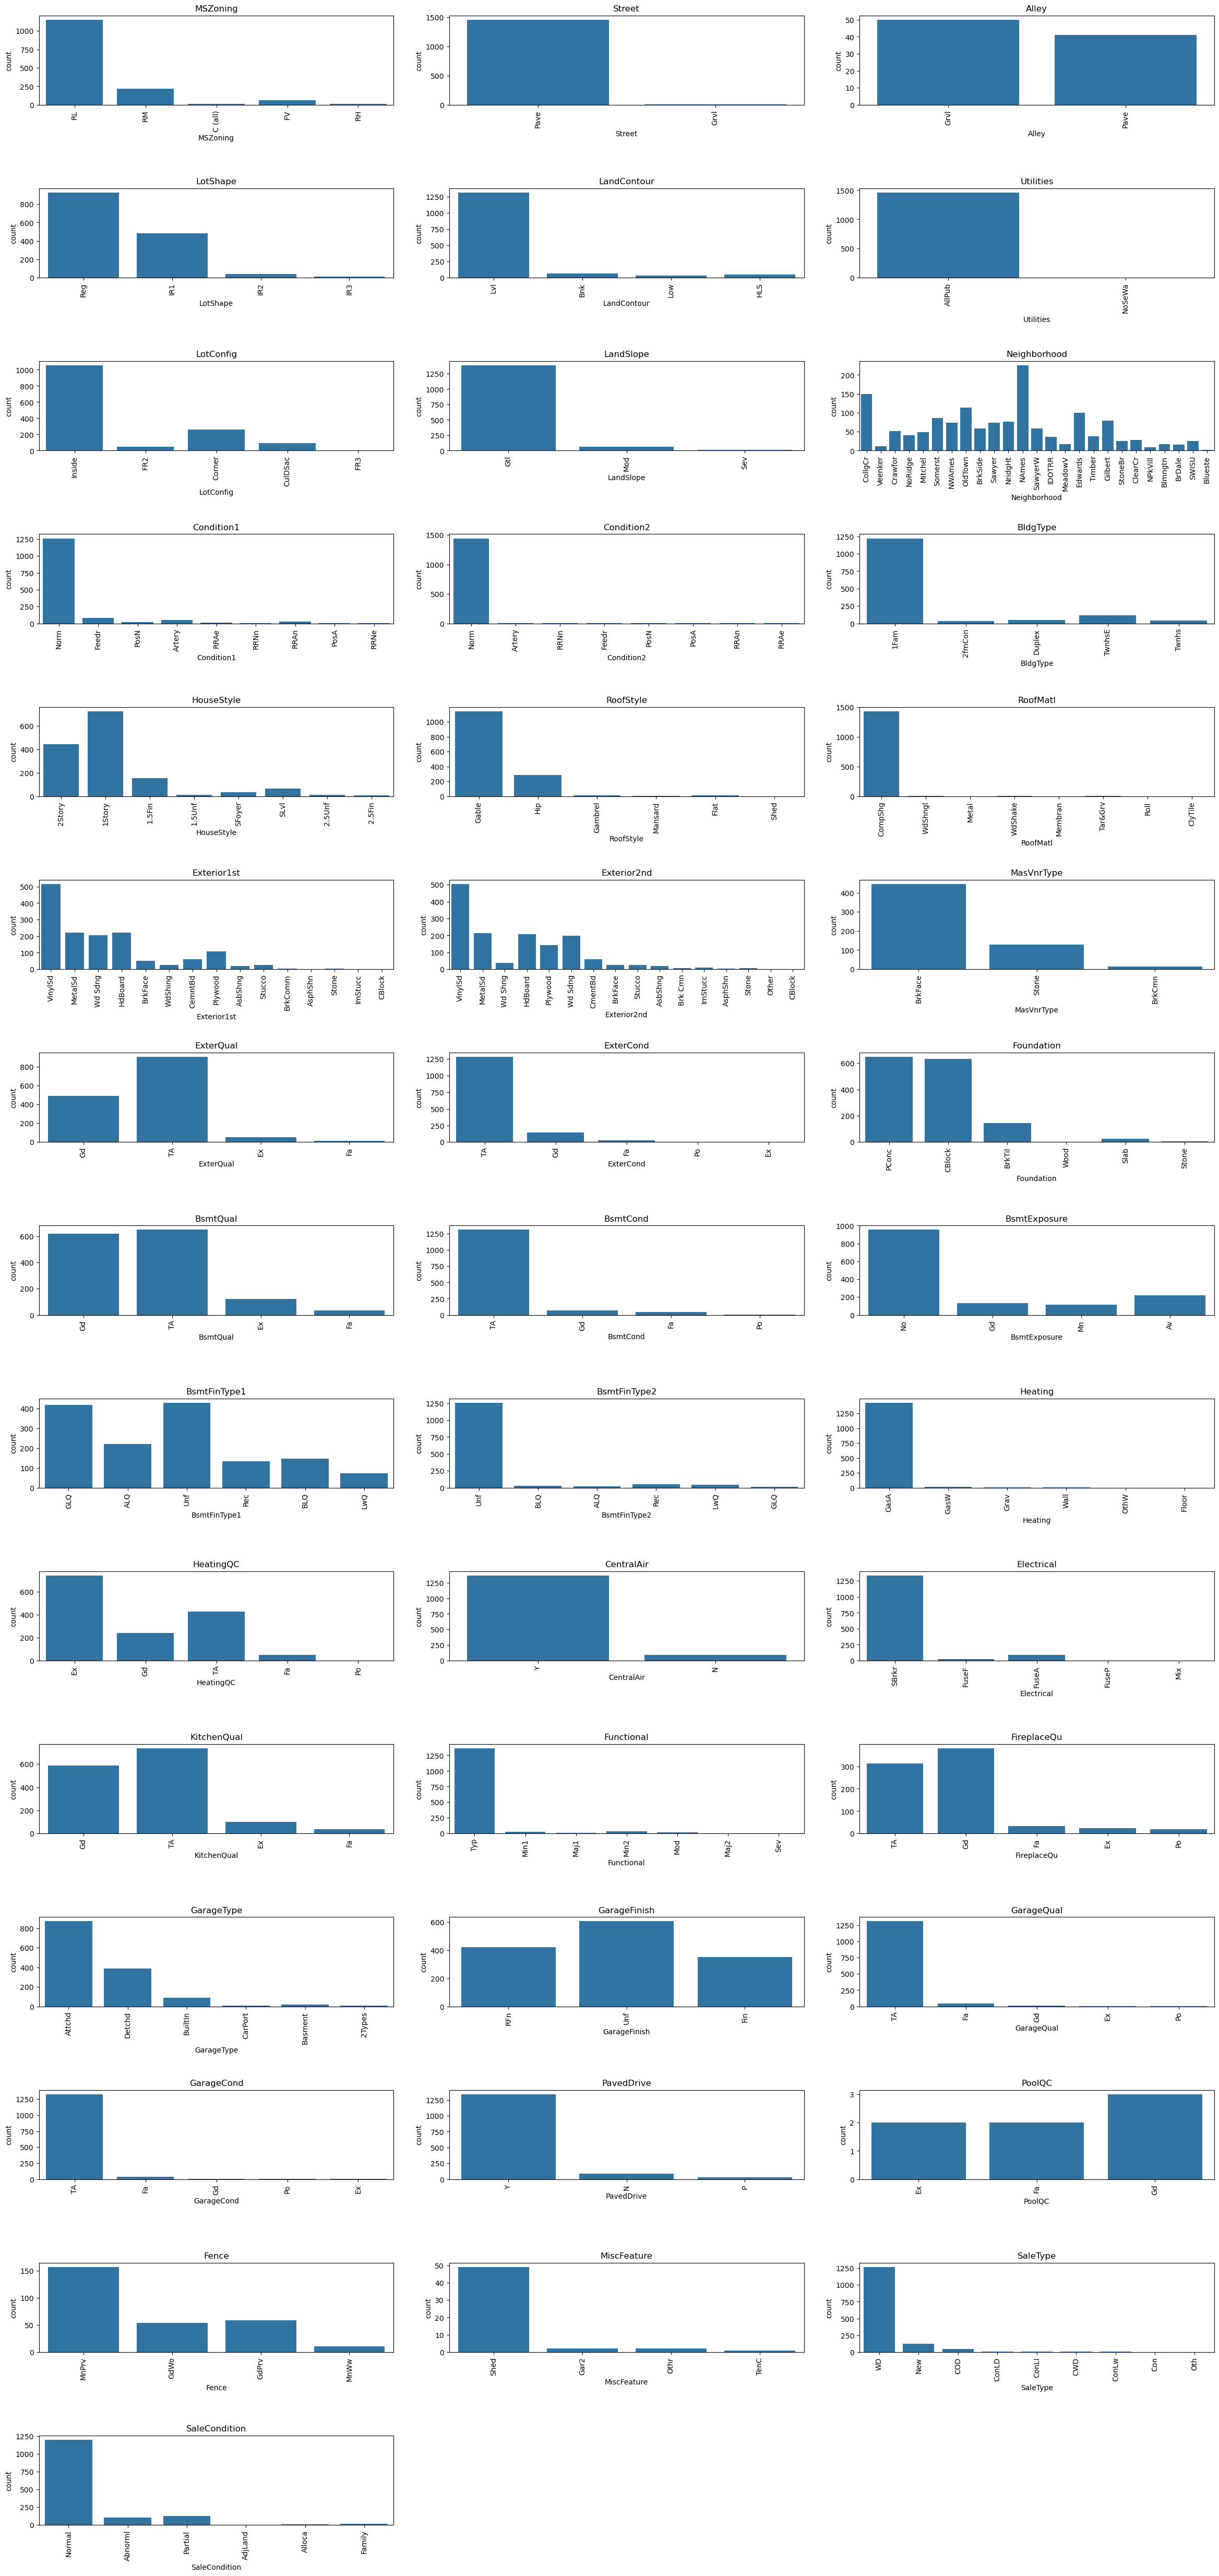

In [60]:
fig = plt.figure(figsize=(24, 50))
for index in range(len(cat_vars.columns)):
    plt.subplot(15, 3, index + 1)
    sns.countplot(x=cat_vars.iloc[:, index], data=cat_vars.dropna())
    plt.xticks(rotation=90)
    plt.title(cat_vars.columns[index])
plt.tight_layout(pad=3.0)

### We can see that many features has values with very few counts, therefore, if a feature has more than 96% of the same value, we will render the feature to be useless and remove it

In [63]:
# remove features with more than 96% of the same value
cat_col = data.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = data[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(data) * 100 > 96:
        overfit_cat.append(i)

data = data.drop(overfit_cat, axis=1)
print("Categorical Features with >96% of the same value: ",overfit_cat)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']


- `Street`
- `Utilities`
- `Condition2`
- `RoofMatl`
- `Heating`

These are the variables with highly repetitive values, we drop them to increase accuracy of models. 

In [66]:
# update variables
num_vars = data.select_dtypes(include='number')
cat_vars = data.select_dtypes(include=['object', 'category'])

### Now, we graph a correlation matrix to: 
1. Explore the realtion bewteen saleprice and feature
2. Investigate any multicollinearity between our independent predictors

<Axes: >

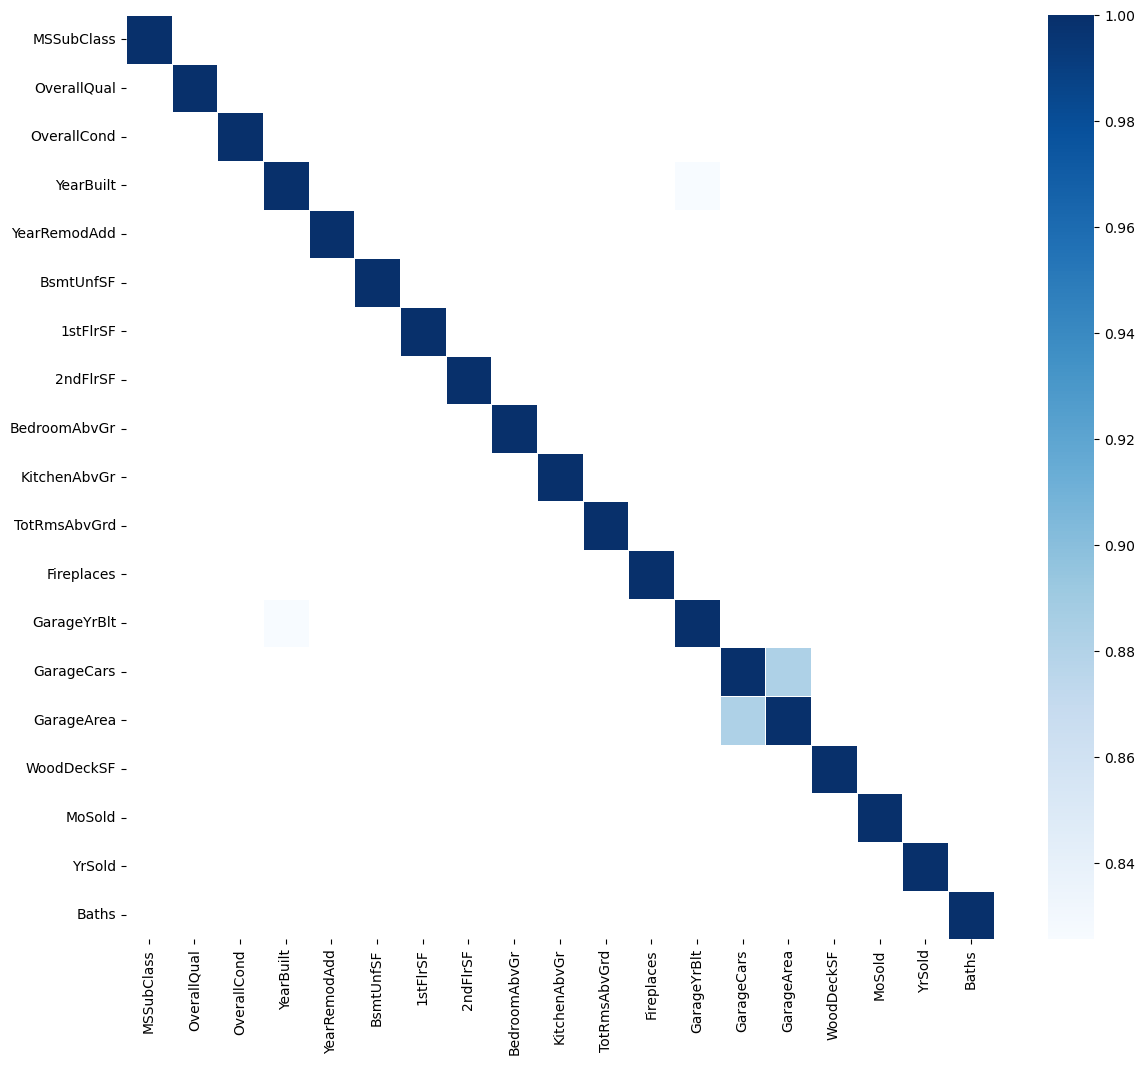

In [69]:
plt.figure(figsize=(14,12))
correlation = num_vars.corr()
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='Blues')

### We can see from the matrix that there are two sets of highly correlated variables:

- `GarageYrBlt` and `YearBuilt`
- `GarageArea` and `GarageCars`

These two sets of features are unsurprisingly correlated. Since we will be using tree-based models for prediction, which are resistant to multicolinearity, we will not remove these features. 

### Next, we use correlation coefficients to examine the correlation between the numeric features and the response variable (SalePrice)

In [73]:
numeric_train = pd.concat([num_vars, train_with_y[["SalePrice"]]], axis = 1)
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GarageCars,0.640409
GarageArea,0.623431
Baths,0.613005
1stFlrSF,0.605852
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101
GarageYrBlt,0.486362


<div style="line-height: 1.8;">
    
### OverallQual and GarageCars have the largest correlation coefficients, indicating that they are strongly correlated with SalePrice. 

### Hence, these 2 features are likely to be important factor in predicting Housing Price.
</div>

### Lastly, we visualize the number of missing values in each feature

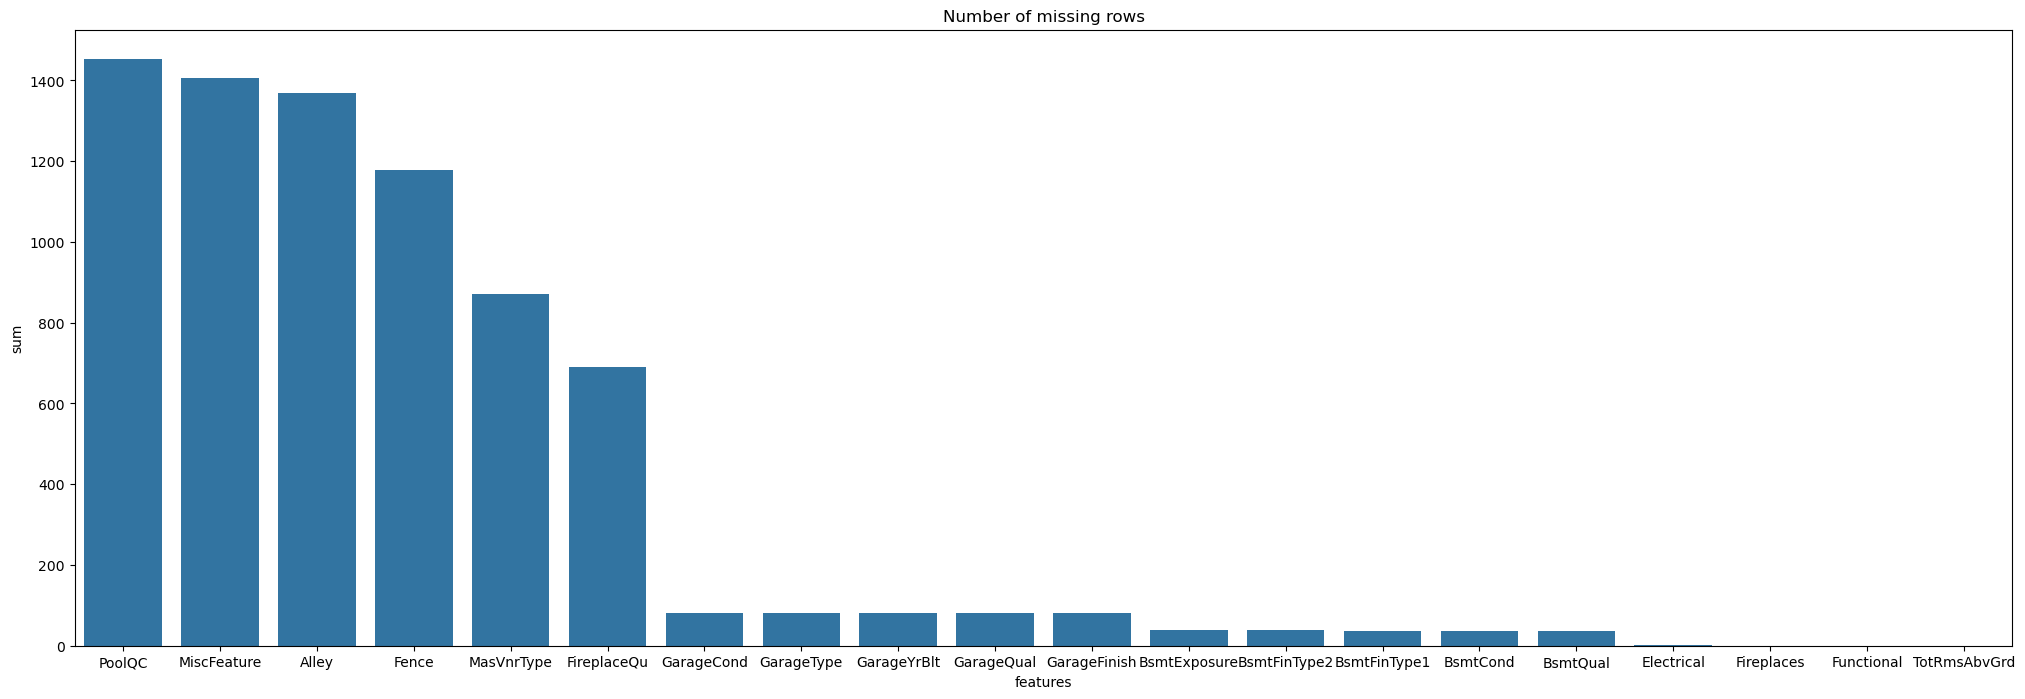

In [77]:
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(data.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)
fig.savefig("missingvalues.png", dpi=300, bbox_inches='tight')

- `PoolQC`
- `MiscFeature`
- `Alley`

These variables have many missing values, so we drop them to improve model accuracy

In [79]:
# remove these variables
values_to_remove = ["PoolQC", "MiscFeature", "Alley"]
data = data.drop(values_to_remove, axis = 1)
num_vars = data.select_dtypes(include='number')
cat_vars = data.select_dtypes(include=['object', 'category'])

## Data Modeling
We will use ensemble methods because of the large number of features involved in this dataset. With so many input variables, using a single model might suffer from high variance, leading to overfitting and poor generalization to new data. By using ensemble techniques, we can combine multiple models to reduce variance and improve the overall robustness and accuracy of the Sales Price predictions.

### Before building models, we need to process the categorical variables

In [83]:
# turn certain categorical variables to binary features
colum = ['2ndFlrSF','WoodDeckSF']

for col in colum:
    col_name = col+'_bin'
    data[col_name] = data[col].apply(lambda x: 1 if x > 0 else 0)

In [85]:
# turn the rest of the categorical variables into dummy variables
data = pd.get_dummies(data)

In [87]:
# prepare x and y variables, then split data
X = data
y = train_with_y["SalePrice"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

### We start with Random Forest

In [90]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# R^2
rfscore = rf.score(X_valid, y_valid)

# RMSE
y_pred = rf.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)

print(f"R²: {rfscore:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Mean of target (y_valid): {y_valid.mean():.3f}")
print(f"Std dev of target (y_valid): {y_valid.std():.3f}")

R²: 0.888
RMSE: 29276.737
Mean of target (y_valid): 178839.812
Std dev of target (y_valid): 87730.751


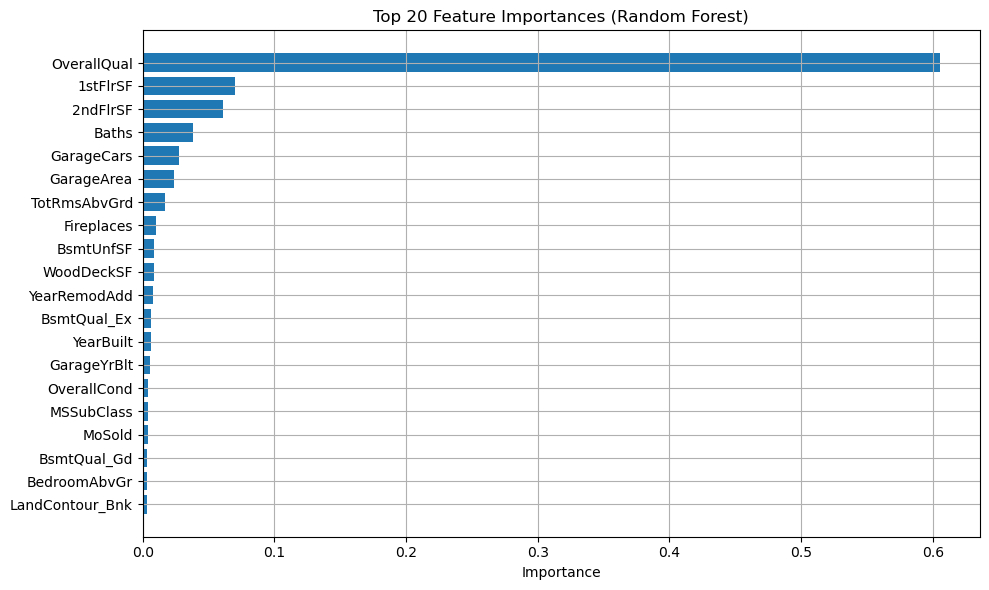

In [92]:
# show feature importance using Random Forest model
importances = rf.feature_importances_
feature_names = X_train.columns

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.grid(True)
plt.show()

### We can see from this plot that `OverallQual`, which stands for overall quality, is the dominant feature

### We move on to the next model: XGBoost

In [95]:
# XGBoost
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

param_lst = {
    'learning_rate': [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0.001, 0.01, 0.1],
    'reg_lambda': [0.001, 0.01, 0.1]
}

In [97]:
xgb_reg = RandomizedSearchCV(
    estimator = xgb,
    param_distributions = param_lst,
    n_iter = 4, 
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    verbose = 1,
    n_jobs = -1
)

xgb_search = xgb_reg.fit(X_train, y_train)
best_param = xgb_search.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [99]:
xgb_best = XGBRegressor(**best_param)
xgb_best.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [100]:
# R^2
xgbscore = xgb_best.score(X_valid, y_valid)

# RMSE
y_pred = xgb_best.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)
xgbscore
print(f"R²: {xgbscore:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Mean of target (y_valid): {y_valid.mean():.3f}")
print(f"Std dev of target (y_valid): {y_valid.std():.3f}")

R²: 0.911
RMSE: 26120.478
Mean of target (y_valid): 178839.812
Std dev of target (y_valid): 87730.751


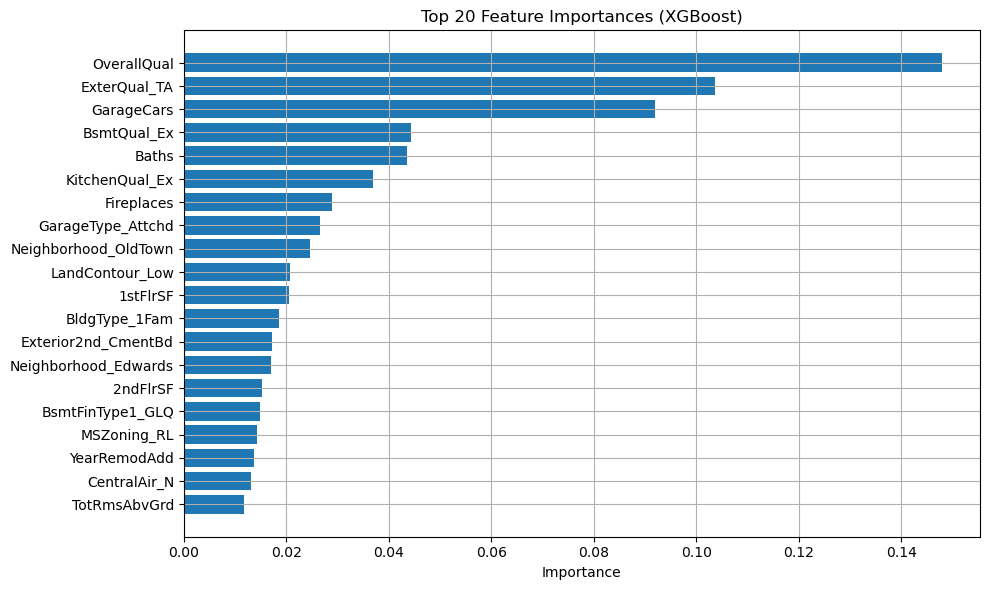

In [101]:
# show feature importance using XG Boost model
importances = xgb_best.feature_importances_
feature_names = X_train.columns

# Create DataFrame
xgb_feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(xgb_feat_imp_df['Feature'], xgb_feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.grid(True)
plt.show()

### From the plot above, we can see the XG Boost selected `OverallQual` as the top predictor, which is consistent with what we got from Random Forest model and the correlation coefficients. 

In [106]:
# Bagging
base_tree = DecisionTreeRegressor()

# Define Bagging Regressor
bagging = BaggingRegressor(estimator=base_tree)

valid_bagging_keys = [
    'n_estimators', 'max_samples', 'max_features', 'bootstrap',
    'estimator__max_depth', 'estimator__min_samples_split'
]

# Filter out invalid params (e.g., reg_lambda from XGBoost)
cleaned_best_param = {k: v for k, v in best_param.items() if k in valid_bagging_keys}

# Split into bagging vs base estimator params
tree_params = {k.replace('estimator__', ''): v for k, v in cleaned_best_param.items() if k.startswith('estimator__')}
bagging_params = {k: v for k, v in cleaned_best_param.items() if not k.startswith('estimator__')}

# Proceed as before
tuned_tree = DecisionTreeRegressor(**tree_params)
bagging_best = BaggingRegressor(estimator=tuned_tree, **bagging_params)
bagging_best.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=500)

In [107]:
# R Squared
r2 = bagging_best.score(X_valid, y_valid)

# RMSE
y_pred = bagging_best.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Mean of target (y_valid): {y_valid.mean():.3f}")
print(f"Std dev of target (y_valid): {y_valid.std():.3f}")

R²: 0.885
RMSE: 29699.197
Mean of target (y_valid): 178839.812
Std dev of target (y_valid): 87730.751


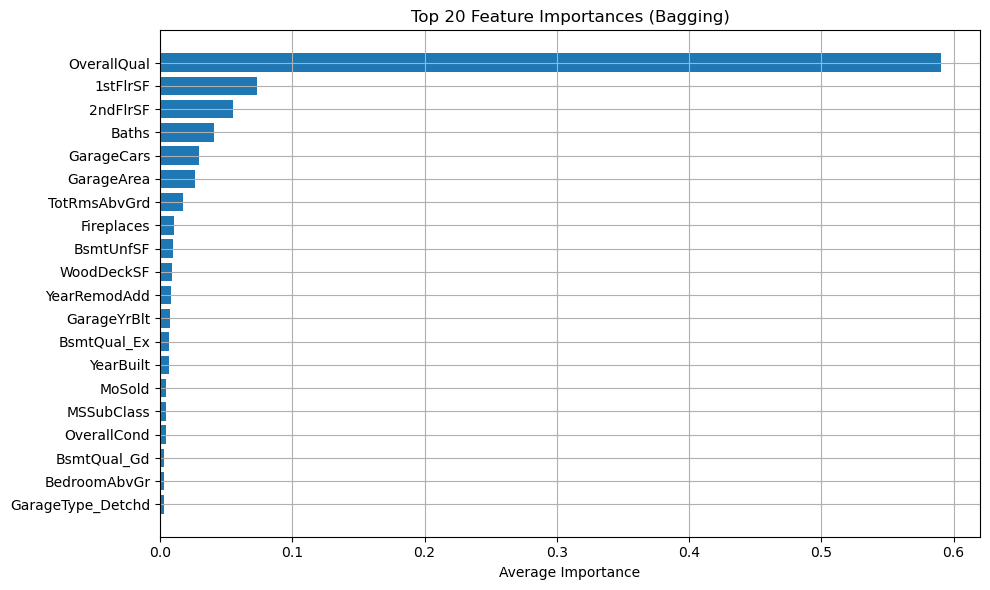

In [110]:
# feature importance based on the Boosting model
feature_names = X_train.columns

# Get feature importances from each base estimator
tree_importances = np.array([
    tree.feature_importances_ for tree in bagging_best.estimators_
])

# Average across all trees
avg_importances = tree_importances.mean(axis=0)

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df = feature_importance_df.head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (Bagging)')
plt.xlabel('Average Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

For data modeling, we used Random Forest, Bagging, and XGBoost models. Random Forest, with an R² of 0.89, handles high-dimensional and mixed-type data well, but it is less interpretable. Bagging also achieved an R² of 0.89 and is easier to implement. It effectively reduces variance by averaging over multiple models, but it cannot capture feature interactions. Both models had a root mean squared error (RMSE) of around \$29,000. 

For context
- mean of target (SalePrice) = \$178839.8
- standard deviation = \$87730.75.

Under comparison, **XGBoost outperformed the others** with the highest R² of 0.91 and the lowest RMSE of approximately \$26,000. Its superior performance can be attributed to its sequential learning process, where each new tree corrects the errors of the previous ones.

## Conclusion
As we can see, XGBoost is the best model when it comes to predicting Sales Price with this dataset. The most important feature according to all our models is `OverallQual` (overall quality), which also has the highest correlation with sales price. Some future work may include looking at other locations to see if our model performs well with the same features. For instance, some places might put an emphasis on specific features of a house.